# Boltzmann: Acrobot

# Constant

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
-90.78


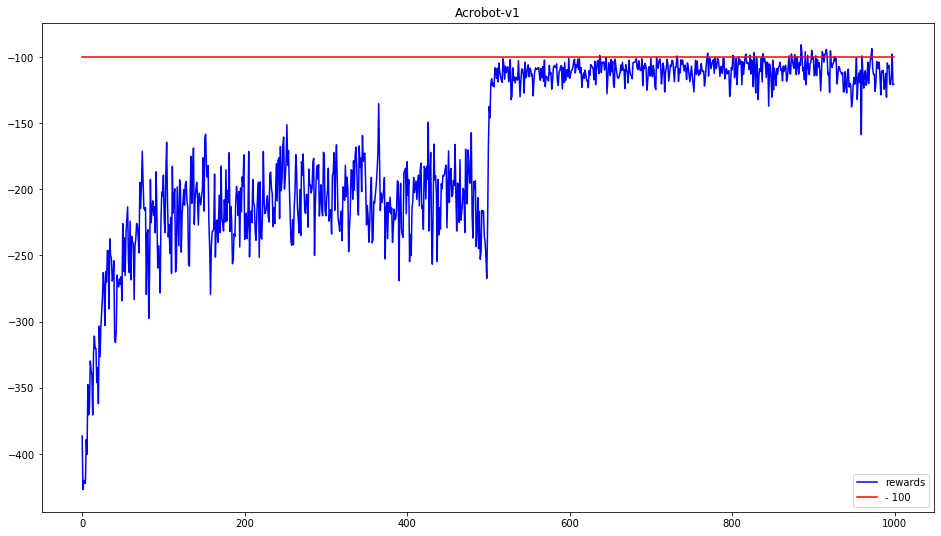

In [6]:
import gym
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import deque
env = gym.make('Acrobot-v1')
import random

#n_actions = env.action_space.n
#n_states = env.observation_space.shape[0]
#print("Action space size: ", n_actions)
#print("State space size: ", n_states)
#print('states high value:')
#print(env.observation_space.high[0]) # 1  cos of first rotational joint 
#print(env.observation_space.high[1])  # 1 sin of first rotational joint
#print(env.observation_space.high[2])  # 1 cos of first rotational joint
#print(env.observation_space.high[3])  # 1 sin of first rotational joint
#print(env.observation_space.high[4])  # 12.566371 angular velocity of 1st joint
#print(env.observation_space.high[5])  # 28.274334 angular velocity of 2nd joint

#print('states low value:')
#print(env.observation_space.low[0])   #-4.8
#print(env.observation_space.low[1])  #-3.4028235e+38
#print(env.observation_space.low[2])  #-0.41887903
#print(env.observation_space.low[3])  #-3.4028235e+38
#print(env.observation_space.low[4])
#print(env.observation_space.low[5])
#[cos(theta1), sin(theta1), cos(theta2), sin(theta2), theta_dot1, theta_dot2]

class Qlearning():  #change the buckets #(self,bins=(1, 1, 1, 1, 12, 24) #(1,1,3,3,6,12) #(2, 2, 2, 2, 8, 12), (1, 1, 1, 1, 6, 11)
    def __init__(self,bins=(1, 1, 1, 1, 6, 13), max_episodes = 2000, max_steps = 500, min_epsilon=0.01, gamma = 1.0, epsilon = 1.0, decay = 25, action_space = env.action_space.n, env = gym.make('Acrobot-v1')):   #max_env_steps=None
        self.bins = bins 
        self.max_episodes = max_episodes
        self.max_steps = max_steps #per episode
        self.min_epsilon = min_epsilon #
        self.epsilon = epsilon
        self.gamma = gamma  
        self.decay = decay
        self.action_space = action_space
        self.env = env
        self.QTable = np.zeros((self.bins + (self.action_space,))) 
        self.alpha = 1 # learning rate
        self.beta = 0.5
        self.actions = None
        self.tau = 1000    # tau --> 0 pure exploitation tau --> infinity pure exploration
        self.tau_decay = True
        self.decay_factor_tau = 1.0

    def discretize(self, state):
        # observation = obs, reward, done, info = self.env.step(action)--> in training
        # define upper and lower bounds for each state value
        #it is necessary to give finite bounds and reduce the range of the cart velocity and pole velocity at tip – i.e. [-0.5, +0.5] and [-50, +50],
        #respectively – in order to be able to discretise.
        upper_bounds = [1.0, 1.0, 1.0, 1.0, env.observation_space.high[4], env.observation_space.high[5]]  
        lower_bounds = [-1.0,-1.0,-1.0,-1.0, env.observation_space.low[4], env.observation_space.low[5]]
        descretizedList = list()
        for i in  range(len(state)): #state = tuple (0,0,X,X)--> aka the state space  #scaling factor
            ratios = (state[i] + abs(lower_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) # (state+lower / bin_width) = bucket size
            new_obs = int(round((self.bins[i] - 1) * ratios)) # makes the first two buckets 0, and #bucket_lower := min_x + bucket × bucket size
            new_obs = min(self.bins[i] - 1, max(0, new_obs)) #no matter what the buckets-1 is going to be 0 or greater than 0
            #this makes sure that the first two components of the tuple is 0
            #why are we taking the min between the bucket-1 and the new_obs
            descretizedList.append(new_obs)
        return tuple(descretizedList)


    def Boltzmann(self, state, tau):
        qList = self.QTable[state] #moves = self.q_matrix[pos_index]
        self.actions = [i for i in range(0, env.action_space.n)]
        if self.tau > 0.0:
            action_probs_numes = []
            denom = 0
            for q in qList:
                val = math.exp(q / self.tau)
                action_probs_numes.append(val)
                denom += val  # summation of the values
            action_probs = []
            for x in action_probs_numes:
                probs = x / denom 
                action_probs.append(probs)    
            prob_sum = 0
            action = random.choices(self.actions, weights=action_probs, k=1)[0] # the weights give a weight to correspond 
        else:
            action = np.argmax(self.QTable[state])
        return action

    def action_policy(self, state, policy):
        return policy[state]
    
    def Q_Update(self, state, action, reward, new_state, step_size):
        ''' Update the Q-values'''
        # self.QTable[old_state][action] += alpha * (reward + self.gamma * np.max(self.Q[state_new]) - self.Q[state_old][action])
        self.QTable[state][action] += step_size * (reward + self.gamma * (np.max(self.QTable[new_state])) - self.QTable[state][action])
        return
    
    def decay_tau(self, t):          
        if self.tau_decay is True:
            #print(t)
            new_tau = self.tau - self.decay_factor_tau
        if new_tau < 0.0:
            self.tau = 0.0
        else:
            self.tau = new_tau
        return new_tau

    def decay_step_size(self, t):
        if t == 0:
            step_size = 1.0
        elif t > 0:
            step_size = self.alpha / (t ** self.beta)  
        return step_size

#1-ln(time unit/decay)
def learning(Qlearning):
    rewards = []
    alphaList = []
    epsilonList = []
    for e in range(Qlearning.max_episodes):  
        state = Qlearning.discretize(env.reset())
        tau = Qlearning.decay_tau(e)
        step_size = 0.01 
        i = 0
        for t in range(Qlearning.max_steps):
            if e % 2 == 0:
                action = Qlearning.Boltzmann(state, tau)
            if e % 2 ==1:
                action = Qlearning.action_policy(state, policy)
            new_state, reward, done, info = env.step(action)
            new_state = Qlearning.discretize(new_state)
            Qlearning.Q_Update(state, action, reward, new_state, step_size)
            state = new_state
            i += reward 
            if done:
                break
        ########### Policy Extraction ##########
        stateTuple = list()
        stateList = []
        actionsList = []
        states = []
        for list1 in Qlearning.QTable:
            for nextList in list1:
                for nextList1 in nextList: 
                    for nextList2 in nextList1:
                        for nextList3 in nextList2:
                            for nextList4 in nextList3:
                                actions = np.argmax(nextList4)
                                actionsList.append(actions)
        observations = np.argwhere(Qlearning.QTable>=-500)
        j = 0
        for obsList in observations:
            stateTuple = (obsList[0], obsList[1], obsList[2], obsList[3], obsList[4], obsList[5])
            stateList.append(stateTuple)
        del stateList[1::3] 
        del stateList[1::2]
        policy = dict(zip(stateList, actionsList))
        if e % 2 == 1:
            rewards.append(i)
            alphaList.append(step_size)
            epsilonList.append(tau)
            mean_rewards =  np.mean(rewards)
    return rewards, alphaList, epsilonList


if __name__ == '__main__':
    ''' Run main program. '''
    #main()
    solve = Qlearning()
    listof_100 = []
    trajectory = []
    for i in range(50):
        solve = Qlearning()
        rewards, alpha, tau = learning(solve)
        trajectory.append(rewards)
        print(i)
    for episode in rewards:
        listof_100.append(-1*100)
    a = np.array(trajectory)
    final = np.mean(a, axis=0)
    meanRewards = []
    print(max(final))
    fig = plt.figure(figsize=(16,9))
    plt.title('Acrobot-v1')
    """plt1 = fig.add_subplot(311)
    plt1.plot(epsilon,  # epsilon_hist,
             color='b',
             label='Epsilon')
    plt1.set(title='Epsilon Plot',
            ylabel='Epsilon',
            xlabel='episodes')
    plt2 = fig.add_subplot(312)
    plt2.plot(alpha,  # epsilon_hist,
             color='b',
             label='Alpha')
    plt2.set(title='Step Size Plot',
            ylabel='Alpha',
            xlabel='episodes')
    plt3 = fig.add_subplot(313)"""
    plt.plot(final,  # epsilon_hist,
             color='b',
             label='rewards')
    plt.plot(listof_100,
             color = 'red',
             label = "- 100")
    """plt3.set(title='Rewards',
            ylabel='Rewards',
            xlabel='episodes')"""
    plt.legend(loc='best')
    plt.show()

# Continually diminishing Step Size

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
-80.56


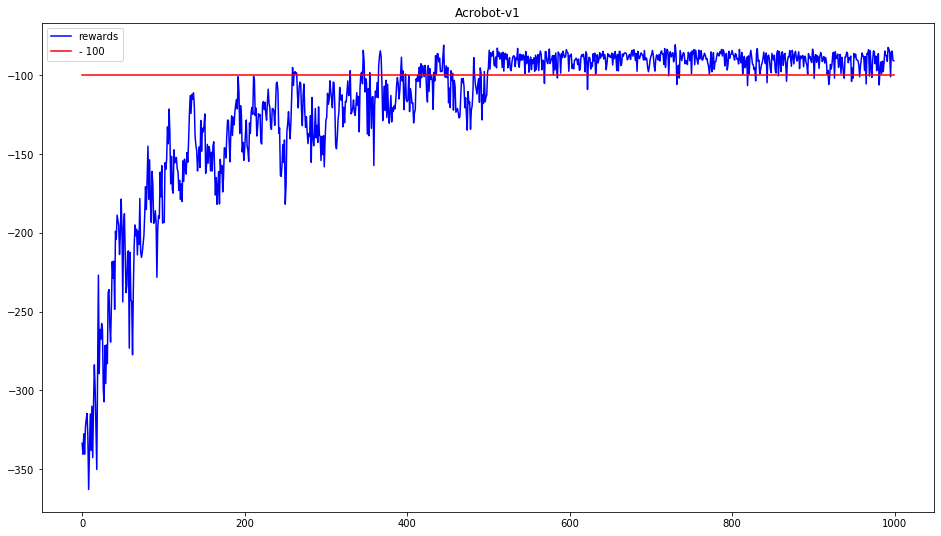

In [1]:
import gym
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import deque
env = gym.make('Acrobot-v1')
import random

#n_actions = env.action_space.n
#n_states = env.observation_space.shape[0]
#print("Action space size: ", n_actions)
#print("State space size: ", n_states)
#print('states high value:')
#print(env.observation_space.high[0]) # 1  cos of first rotational joint 
#print(env.observation_space.high[1])  # 1 sin of first rotational joint
#print(env.observation_space.high[2])  # 1 cos of first rotational joint
#print(env.observation_space.high[3])  # 1 sin of first rotational joint
#print(env.observation_space.high[4])  # 12.566371 angular velocity of 1st joint
#print(env.observation_space.high[5])  # 28.274334 angular velocity of 2nd joint

#print('states low value:')
#print(env.observation_space.low[0])   #-4.8
#print(env.observation_space.low[1])  #-3.4028235e+38
#print(env.observation_space.low[2])  #-0.41887903
#print(env.observation_space.low[3])  #-3.4028235e+38
#print(env.observation_space.low[4])
#print(env.observation_space.low[5])
#[cos(theta1), sin(theta1), cos(theta2), sin(theta2), theta_dot1, theta_dot2]

class Qlearning():  #change the buckets #(self,bins=(1, 1, 1, 1, 12, 24) #(1,1,3,3,6,12) #(2, 2, 2, 2, 8, 12), (1, 1, 1, 1, 6, 11)
    def __init__(self,bins=(1, 1, 1, 1, 6, 13), max_episodes = 2000, max_steps = 500, min_epsilon=0.01, gamma = 1.0, epsilon = 1.0, decay = 25, action_space = env.action_space.n, env = gym.make('Acrobot-v1')):   #max_env_steps=None
        self.bins = bins 
        self.max_episodes = max_episodes
        self.max_steps = max_steps #per episode
        self.min_epsilon = min_epsilon #
        self.epsilon = epsilon
        self.gamma = gamma  
        self.decay = decay
        self.action_space = action_space
        self.env = env
        self.QTable = np.zeros((self.bins + (self.action_space,))) 
        self.alpha = 1 # learning rate
        self.beta = 0.5
        self.actions = None
        self.tau = 1000    # tau --> 0 pure exploitation tau --> infinity pure exploration
        self.tau_decay = True
        self.decay_factor_tau = 1.0

    def discretize(self, state):
        # observation = obs, reward, done, info = self.env.step(action)--> in training
        # define upper and lower bounds for each state value
        #it is necessary to give finite bounds and reduce the range of the cart velocity and pole velocity at tip – i.e. [-0.5, +0.5] and [-50, +50],
        #respectively – in order to be able to discretise.
        upper_bounds = [1.0, 1.0, 1.0, 1.0, env.observation_space.high[4], env.observation_space.high[5]]  
        lower_bounds = [-1.0,-1.0,-1.0,-1.0, env.observation_space.low[4], env.observation_space.low[5]]
        descretizedList = list()
        for i in  range(len(state)): #state = tuple (0,0,X,X)--> aka the state space  #scaling factor
            ratios = (state[i] + abs(lower_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) # (state+lower / bin_width) = bucket size
            new_obs = int(round((self.bins[i] - 1) * ratios)) # makes the first two buckets 0, and #bucket_lower := min_x + bucket × bucket size
            new_obs = min(self.bins[i] - 1, max(0, new_obs)) #no matter what the buckets-1 is going to be 0 or greater than 0
            #this makes sure that the first two components of the tuple is 0
            #why are we taking the min between the bucket-1 and the new_obs
            descretizedList.append(new_obs)
        return tuple(descretizedList)


    def Boltzmann(self, state, tau):
        qList = self.QTable[state] #moves = self.q_matrix[pos_index]
        self.actions = [i for i in range(0, env.action_space.n)]
        if self.tau > 0.0:
            action_probs_numes = []
            denom = 0
            for q in qList:
                val = math.exp(q / self.tau)
                action_probs_numes.append(val)
                denom += val  # summation of the values
            action_probs = []
            for x in action_probs_numes:
                probs = x / denom 
                action_probs.append(probs)    
            prob_sum = 0
            action = random.choices(self.actions, weights=action_probs, k=1)[0] # the weights give a weight to correspond 
        else:
            action = np.argmax(self.QTable[state])
        return action

    def action_policy(self, state, policy):
        return policy[state]
    
    def Q_Update(self, state, action, reward, new_state, step_size):
        ''' Update the Q-values'''
        # self.QTable[old_state][action] += alpha * (reward + self.gamma * np.max(self.Q[state_new]) - self.Q[state_old][action])
        self.QTable[state][action] += step_size * (reward + self.gamma * (np.max(self.QTable[new_state])) - self.QTable[state][action])
        return
    
    def decay_tau(self, t):          
        if self.tau_decay is True:
            #print(t)
            new_tau = self.tau - self.decay_factor_tau
        if new_tau < 0.0:
            self.tau = 0.0
        else:
            self.tau = new_tau
        return new_tau

    def decay_step_size(self, tt, e, t):
        num = self.alpha
        dem = tt**self.beta
        if e == 0 and t == 0:
            step_size = 1
        elif tt > 0:
            step_size = num / dem
        return step_size

#1-ln(time unit/decay)
def learning(Qlearning):
    rewards = []
    alphaList = []
    epsilonList = []
    tt = 0
    for e in range(Qlearning.max_episodes):  
        state = Qlearning.discretize(env.reset())
        tau = Qlearning.decay_tau(e)
        i = 0
        for t in range(Qlearning.max_steps):
            step_size = Qlearning.decay_step_size(tt,e,t)
            tt+=1
            if e % 2 == 0:
                action = Qlearning.Boltzmann(state, tau)
            if e % 2 ==1:
                action = Qlearning.action_policy(state, policy)
            new_state, reward, done, info = env.step(action)
            new_state = Qlearning.discretize(new_state)
            Qlearning.Q_Update(state, action, reward, new_state, step_size)
            state = new_state
            i += reward 
            if done:
                break
        ########### Policy Extraction ##########
        stateTuple = list()
        stateList = []
        actionsList = []
        states = []
        for list1 in Qlearning.QTable:
            for nextList in list1:
                for nextList1 in nextList: 
                    for nextList2 in nextList1:
                        for nextList3 in nextList2:
                            for nextList4 in nextList3:
                                actions = np.argmax(nextList4)
                                actionsList.append(actions)
        observations = np.argwhere(Qlearning.QTable>=-500)
        j = 0
        for obsList in observations:
            stateTuple = (obsList[0], obsList[1], obsList[2], obsList[3], obsList[4], obsList[5])
            stateList.append(stateTuple)
        del stateList[1::3] 
        del stateList[1::2]
        policy = dict(zip(stateList, actionsList))
        if e % 2 == 1:
            rewards.append(i)
            alphaList.append(step_size)
            epsilonList.append(tau)
            mean_rewards =  np.mean(rewards)
    return rewards, alphaList, epsilonList


if __name__ == '__main__':
    ''' Run main program. '''
    #main()
    solve = Qlearning()
    listof_100 = []
    trajectory = []
    for i in range(50):
        solve = Qlearning()
        rewards, alpha, tau = learning(solve)
        trajectory.append(rewards)
        print(i)
    for episode in rewards:
        listof_100.append(-1*100)
    a = np.array(trajectory)
    final = np.mean(a, axis=0)
    meanRewards = []
    print(max(final))
    fig = plt.figure(figsize=(16,9))
    plt.title('Acrobot-v1')
    """plt1 = fig.add_subplot(311)
    plt1.plot(epsilon,  # epsilon_hist,
             color='b',
             label='Epsilon')
    plt1.set(title='Epsilon Plot',
            ylabel='Epsilon',
            xlabel='episodes')
    plt2 = fig.add_subplot(312)
    plt2.plot(alpha,  # epsilon_hist,
             color='b',
             label='Alpha')
    plt2.set(title='Step Size Plot',
            ylabel='Alpha',
            xlabel='episodes')
    plt3 = fig.add_subplot(313)"""
    plt.plot(final,  # epsilon_hist,
             color='b',
             label='rewards')
    plt.plot(listof_100,
             color = 'red',
             label = "- 100")
    """plt3.set(title='Rewards',
            ylabel='Rewards',
            xlabel='episodes')"""
    plt.legend(loc='best')
    plt.show()

# Restarting Diminishing Step Size

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
-113.88


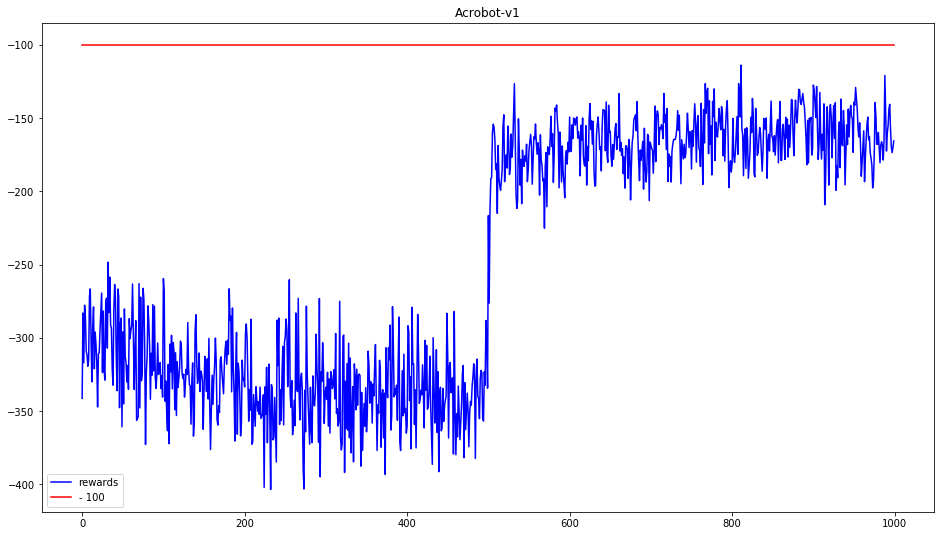

In [4]:
import gym
import numpy as np
import math
import matplotlib.pyplot as plt
from collections import deque
env = gym.make('Acrobot-v1')
import random

#n_actions = env.action_space.n
#n_states = env.observation_space.shape[0]
#print("Action space size: ", n_actions)
#print("State space size: ", n_states)
#print('states high value:')
#print(env.observation_space.high[0]) # 1  cos of first rotational joint 
#print(env.observation_space.high[1])  # 1 sin of first rotational joint
#print(env.observation_space.high[2])  # 1 cos of first rotational joint
#print(env.observation_space.high[3])  # 1 sin of first rotational joint
#print(env.observation_space.high[4])  # 12.566371 angular velocity of 1st joint
#print(env.observation_space.high[5])  # 28.274334 angular velocity of 2nd joint

#print('states low value:')
#print(env.observation_space.low[0])   #-4.8
#print(env.observation_space.low[1])  #-3.4028235e+38
#print(env.observation_space.low[2])  #-0.41887903
#print(env.observation_space.low[3])  #-3.4028235e+38
#print(env.observation_space.low[4])
#print(env.observation_space.low[5])
#[cos(theta1), sin(theta1), cos(theta2), sin(theta2), theta_dot1, theta_dot2]

class Qlearning():  #change the buckets #(self,bins=(1, 1, 1, 1, 12, 24) #(1,1,3,3,6,12) #(2, 2, 2, 2, 8, 12), (1, 1, 1, 1, 6, 11)
    def __init__(self,bins=(1, 1, 1, 1, 6, 13), max_episodes = 2000, max_steps = 500, min_epsilon=0.01, gamma = 1.0, epsilon = 1.0, decay = 25, action_space = env.action_space.n, env = gym.make('Acrobot-v1')):   #max_env_steps=None
        self.bins = bins 
        self.max_episodes = max_episodes
        self.max_steps = max_steps #per episode
        self.min_epsilon = min_epsilon #
        self.epsilon = epsilon
        self.gamma = gamma  
        self.decay = decay
        self.action_space = action_space
        self.env = env
        self.QTable = np.zeros((self.bins + (self.action_space,))) 
        self.alpha = 1 # learning rate
        self.beta = 0.5
        self.actions = None
        self.tau = 1000    # tau --> 0 pure exploitation tau --> infinity pure exploration
        self.tau_decay = True
        self.decay_factor_tau = 1.0

    def discretize(self, state):
        # observation = obs, reward, done, info = self.env.step(action)--> in training
        # define upper and lower bounds for each state value
        #it is necessary to give finite bounds and reduce the range of the cart velocity and pole velocity at tip – i.e. [-0.5, +0.5] and [-50, +50],
        #respectively – in order to be able to discretise.
        upper_bounds = [1.0, 1.0, 1.0, 1.0, env.observation_space.high[4], env.observation_space.high[5]]  
        lower_bounds = [-1.0,-1.0,-1.0,-1.0, env.observation_space.low[4], env.observation_space.low[5]]
        descretizedList = list()
        for i in  range(len(state)): #state = tuple (0,0,X,X)--> aka the state space  #scaling factor
            ratios = (state[i] + abs(lower_bounds[i])) / (upper_bounds[i] - lower_bounds[i]) # (state+lower / bin_width) = bucket size
            new_obs = int(round((self.bins[i] - 1) * ratios)) # makes the first two buckets 0, and #bucket_lower := min_x + bucket × bucket size
            new_obs = min(self.bins[i] - 1, max(0, new_obs)) #no matter what the buckets-1 is going to be 0 or greater than 0
            #this makes sure that the first two components of the tuple is 0
            #why are we taking the min between the bucket-1 and the new_obs
            descretizedList.append(new_obs)
        return tuple(descretizedList)


    def Boltzmann(self, state, tau):
        qList = self.QTable[state] #moves = self.q_matrix[pos_index]
        self.actions = [i for i in range(0, env.action_space.n)]
        if self.tau > 0.0:
            action_probs_numes = []
            denom = 0
            for q in qList:
                val = math.exp(q / self.tau)
                action_probs_numes.append(val)
                denom += val  # summation of the values
            action_probs = []
            for x in action_probs_numes:
                probs = x / denom 
                action_probs.append(probs)    
            prob_sum = 0
            action = random.choices(self.actions, weights=action_probs, k=1)[0] # the weights give a weight to correspond 
        else:
            action = np.argmax(self.QTable[state])
        return action

    def action_policy(self, state, policy):
        return policy[state]
    
    def Q_Update(self, state, action, reward, new_state, step_size):
        ''' Update the Q-values'''
        # self.QTable[old_state][action] += alpha * (reward + self.gamma * np.max(self.Q[state_new]) - self.Q[state_old][action])
        self.QTable[state][action] += step_size * (reward + self.gamma * (np.max(self.QTable[new_state])) - self.QTable[state][action])
        return
    
    def decay_tau(self, t):          
        if self.tau_decay is True:
            #print(t)
            new_tau = self.tau - self.decay_factor_tau
        if new_tau < 0.0:
            self.tau = 0.0
        else:
            self.tau = new_tau
        return new_tau

    def decay_step_size(self, t):
        if t == 0:
            step_size = 1.0
        elif t > 0:
            step_size = self.alpha / (t ** self.beta)  
        return step_size

#1-ln(time unit/decay)
def learning(Qlearning):
    rewards = []
    alphaList = []
    epsilonList = []
    for e in range(Qlearning.max_episodes):  
        state = Qlearning.discretize(env.reset())
        tau = Qlearning.decay_tau(e)
        step_size = 1 #0.01 
        i = 0
        for t in range(Qlearning.max_steps):
            step_size = Qlearning.decay_step_size(t)
            if e % 2 == 0:
                action = Qlearning.Boltzmann(state, tau)
            if e % 2 ==1:
                action = Qlearning.action_policy(state, policy)
            new_state, reward, done, info = env.step(action)
            new_state = Qlearning.discretize(new_state)
            Qlearning.Q_Update(state, action, reward, new_state, step_size)
            state = new_state
            i += reward 
            if done:
                break
        ########### Policy Extraction ##########
        stateTuple = list()
        stateList = []
        actionsList = []
        states = []
        for list1 in Qlearning.QTable:
            for nextList in list1:
                for nextList1 in nextList: 
                    for nextList2 in nextList1:
                        for nextList3 in nextList2:
                            for nextList4 in nextList3:
                                actions = np.argmax(nextList4)
                                actionsList.append(actions)
        observations = np.argwhere(Qlearning.QTable>=-10000)
        j = 0
        for obsList in observations:
            stateTuple = (obsList[0], obsList[1], obsList[2], obsList[3], obsList[4], obsList[5])
            stateList.append(stateTuple)
        del stateList[1::3] 
        del stateList[1::2]
        policy = dict(zip(stateList, actionsList))
        if e % 2 == 1:
            rewards.append(i)
            alphaList.append(step_size)
            epsilonList.append(tau)
            mean_rewards =  np.mean(rewards)
    return rewards, alphaList, epsilonList


if __name__ == '__main__':
    ''' Run main program. '''
    #main()
    solve = Qlearning()
    listof_100 = []
    trajectory = []
    for i in range(50):
        solve = Qlearning()
        rewards, alpha, tau = learning(solve)
        trajectory.append(rewards)
        print(i)
    for episode in rewards:
        listof_100.append(-1*100)
    a = np.array(trajectory)
    final = np.mean(a, axis=0)
    meanRewards = []
    print(max(final))
    fig = plt.figure(figsize=(16,9))
    plt.title('Acrobot-v1')
    """plt1 = fig.add_subplot(311)
    plt1.plot(epsilon,  # epsilon_hist,
             color='b',
             label='Epsilon')
    plt1.set(title='Epsilon Plot',
            ylabel='Epsilon',
            xlabel='episodes')
    plt2 = fig.add_subplot(312)
    plt2.plot(alpha,  # epsilon_hist,
             color='b',
             label='Alpha')
    plt2.set(title='Step Size Plot',
            ylabel='Alpha',
            xlabel='episodes')
    plt3 = fig.add_subplot(313)"""
    plt.plot(final,  # epsilon_hist,
             color='b',
             label='rewards')
    plt.plot(listof_100,
             color = 'red',
             label = "- 100")
    """plt3.set(title='Rewards',
            ylabel='Rewards',
            xlabel='episodes')"""
    plt.legend(loc='best')
    plt.show()